# Get the Class names 

This file contains a subset of the quick draw classes. I choose around 100 classes from the dataset. 
Base on code from Zaid Alyafeai

In [2]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'

--2020-07-21 19:03:19--  https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘mini_classes.txt’

mini_classes.txt    100%[===================>]     760  --.-KB/s    in 0s      

2020-07-21 19:03:20 (50.7 MB/s) - ‘mini_classes.txt’ saved [760/760]



Read the classes names 

In [3]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [4]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the Dataset 

Loop over the classes and download the currospondent data

In [5]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [6]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [7]:
download() 

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

# Imports 

In [7]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

# Load the Data 

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 5000 images per class.  

In [8]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [9]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [10]:
print(len(x_train))

320000


Show some random data 

door


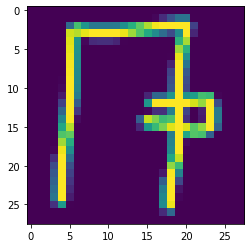

In [11]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

# Preprocess the Data 

In [12]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model 

In [13]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax')) 
# Train model

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

# Training 

In [14]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Epoch 1/5
1125/1125 - 125s - loss: 1.9297 - top_k_categorical_accuracy: 0.7812 - val_loss: 1.3613 - val_top_k_categorical_accuracy: 0.8787
Epoch 2/5
1125/1125 - 127s - loss: 1.2440 - top_k_categorical_accuracy: 0.8929 - val_loss: 1.1672 - val_top_k_categorical_accuracy: 0.9008
Epoch 3/5
1125/1125 - 126s - loss: 1.0827 - top_k_categorical_accuracy: 0.9109 - val_loss: 1.0526 - val_top_k_categorical_accuracy: 0.9131
Epoch 4/5
1125/1125 - 127s - loss: 0.9928 - top_k_categorical_accuracy: 0.9204 - val_loss: 0.9722 - val_top_k_categorical_accuracy: 0.9210
Epoch 5/5
1125/1125 - 126s - loss: 0.9323 - top_k_categorical_accuracy: 0.9260 - val_loss: 0.9413 - val_top_k_categorical_accuracy: 0.9233


# Testing 

In [15]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 92.36%


# Inference 

['radio', 'butterfly', 'drums', 'ceiling_fan', 'bicycle']


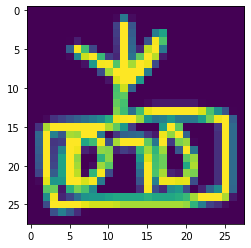

In [16]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

# Store the classes 

In [17]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [18]:
!pip install tensorflowjs 

  Using cached https://files.pythonhosted.org/packages/ee/3d/b25d35a9f0d381dd1c02d8e04b37c353caaaff4bc32150328eeebe4931f5/prompt_toolkit-1.0.14-py3-none-any.whl
ERROR: ipython 7.16.1 has requirement prompt-toolkit!=3.0.0,!=3.0.1,<3.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.14 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.16.1 which is incompatible.
  Found existing installation: prompt-toolkit 3.0.5
    Uninstalling prompt-toolkit-3.0.5:
      Successfully uninstalled prompt-toolkit-3.0.5


In [19]:
!pip install -U ipython

Requirement already up-to-date: ipython in /usr/local/lib/python3.6/dist-packages (7.16.1)
  Using cached https://files.pythonhosted.org/packages/e4/a7/81b39aa50e9284fe2cb21cc7fb7de7817b224172d42793fd57451d38842b/prompt_toolkit-3.0.5-py3-none-any.whl
ERROR: pyinquirer 1.0.3 has requirement prompt-toolkit==1.0.14, but you'll have prompt-toolkit 3.0.5 which is incompatible.
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.5 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.16.1 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.14
    Uninstalling prompt-toolkit-1.0.14:
      Successfully uninstalled prompt-toolkit-1.0.14


# Save and Convert 

In [20]:
model.save('keras.h5')

In [21]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

# Zip and Download 

In [22]:
!cp class_names.txt model/class_names.txt

In [23]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/class_names.txt (deflated 42%)
  adding: model/model.json (deflated 82%)
  adding: model/group1-shard1of1.bin (deflated 7%)


In [25]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>